# Move all images from dollar street trial into the negative folder

In [1]:
import os 
DATASET_PATH = r"C:\Users\holog\Downloads\Dollar street trial"
NEGATIVE_PATH = r"C:\Users\holog\Desktop\machine_learning\similarity\negative"

"""
for directory in os.listdir(DATASET_PATH):
    for file in os.listdir(os.path.join(DATASET_PATH, directory, "img")):
        EX_PATH = os.path.join(DATASET_PATH, directory, "img", file)
        NEW_PATH = os.path.join(NEGATIVE_PATH, file)
        try:
            os.rename(EX_PATH, NEW_PATH)
        except:
            pass
"""

'\nfor directory in os.listdir(DATASET_PATH):\n    for file in os.listdir(os.path.join(DATASET_PATH, directory, "img")):\n        EX_PATH = os.path.join(DATASET_PATH, directory, "img", file)\n        NEW_PATH = os.path.join(NEGATIVE_PATH, file)\n        try:\n            os.rename(EX_PATH, NEW_PATH)\n        except:\n            pass\n'

# Get images as (anchor, second_image, label)
1 if second image is positive, 0 if negative

In [28]:
import os 

TRAIN_PATH = r"C:\Users\holog\Desktop\machine_learning\similarity\train"

positive_pairs = []
negative_pairs = []

# Anchor images are in train/directory/anchor for each directory
for category in os.listdir(TRAIN_PATH):
    anchor_dir = os.path.join(TRAIN_PATH, category, "anchor")
    positive_dir = os.path.join(TRAIN_PATH, category, "positive")
    negative_dir = os.path.join(TRAIN_PATH, category, "negative")

    anchor_list = [os.path.join(anchor_dir, f) for f in os.listdir(anchor_dir)]
    positive_list = [os.path.join(positive_dir, f) for f in os.listdir(positive_dir)]
    negative_list = [os.path.join(negative_dir, f) for f in os.listdir(negative_dir)]

    # Within each category directory, match each anchor with each positive and negative 
    positive_pairs += [(a, p, 1) for a in anchor_list for p in positive_list]
    negative_pairs += [(a, n, 0) for a in anchor_list for n in negative_list]

data = positive_pairs + negative_pairs 

data

[('C:\\Users\\holog\\Desktop\\machine_learning\\similarity\\train\\fan\\anchor\\20250131_001207.jpg',
  'C:\\Users\\holog\\Desktop\\machine_learning\\similarity\\train\\fan\\positive\\20250131_001223.jpg',
  1),
 ('C:\\Users\\holog\\Desktop\\machine_learning\\similarity\\train\\fan\\anchor\\20250131_001207.jpg',
  'C:\\Users\\holog\\Desktop\\machine_learning\\similarity\\train\\fan\\positive\\20250131_001241.jpg',
  1),
 ('C:\\Users\\holog\\Desktop\\machine_learning\\similarity\\train\\fan\\anchor\\20250131_001207.jpg',
  'C:\\Users\\holog\\Desktop\\machine_learning\\similarity\\train\\fan\\positive\\20250131_001253.jpg',
  1),
 ('C:\\Users\\holog\\Desktop\\machine_learning\\similarity\\train\\fan\\anchor\\20250131_001207.jpg',
  'C:\\Users\\holog\\Desktop\\machine_learning\\similarity\\train\\fan\\positive\\20250131_001257.jpg',
  1),
 ('C:\\Users\\holog\\Desktop\\machine_learning\\similarity\\train\\fan\\anchor\\20250131_001232.jpg',
  'C:\\Users\\holog\\Desktop\\machine_learning\\si

# Preprocess images

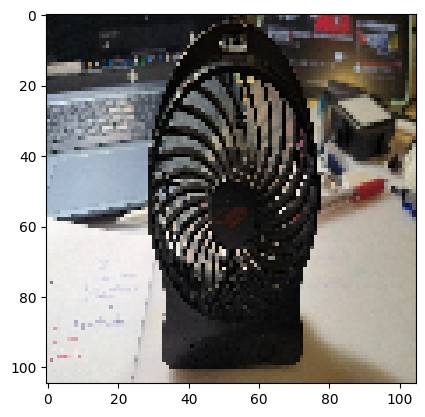

In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt 

def preprocess(image_path):
    byte_img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (105, 105))  # Resize to 105x105x3 (3 color channels)
    img = img / 255.0  # Scale image between 0 and 1
    return img 

# The first anchor image is shown
test = preprocess(data[0][0])
plt.imshow(test)

# Create labelled dataset (1 and 0)

0


<ShuffleDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

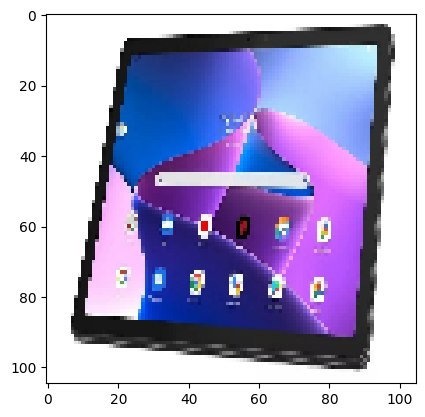

In [31]:
# Convert to tf dataset 
i1_paths, i2_paths, labels = zip(*data)
i1_dataset = tf.data.Dataset.from_tensor_slices(list(i1_paths)).map(preprocess)  # Preprocess the images 
i2_dataset = tf.data.Dataset.from_tensor_slices(list(i2_paths)).map(preprocess)
label_dataset = tf.data.Dataset.from_tensor_slices(list(labels))

dataset = tf.data.Dataset.zip((i1_dataset, i2_dataset, label_dataset))
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=1024)

# Check 
samples = dataset.as_numpy_iterator()
next = samples.next()
print(next[2])  # next[0] is the anchor, next[1] is the positive, next[2] is the negative
# Hence, if 1 is printed, the image is positive, else the image should be negative:
plt.imshow(next[1])

# Should show a different image everytime 
dataset  

# Partition into train and test data

In [5]:
print(len(dataset))

BATCH_SIZE = 2

train_data = dataset.take(round(len(dataset)*0.7))
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(8)

test_data = dataset.skip(round(len(dataset)*0.7))
test_data = test_data.take(round(len(dataset)*0.3))
test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(8)

# Check
train_sample = train_data.as_numpy_iterator().next()
print(train_data)
print(len(train_sample))  # 3
print(len(train_sample[0]))  # 16

34
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
3
2


# Build embedding layer

In [6]:
import tensorflow as tf 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

def make_embedding():
    inp = Input(shape=(105, 105, 3))

    c1 = Conv2D(64, (10, 10), activation="relu")(inp)  # Convolution + ReLU
    m1 = MaxPooling2D(64, (2,2), padding="same")(c1)  # Max pooling

    c2 = Conv2D(128, (7,7), activation="relu")(m1)
    m2 = MaxPooling2D(64, (2,2), padding="same")(c2)

    c3 = Conv2D(128, (4,4), activation="relu")(m2)
    m3 = MaxPooling2D(64, (2,2), padding="same")(c3)

    c4 = Conv2D(256, (4,4), activation="relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = "sigmoid")(f1)   # Fully connected layer 

    return Model(inputs=[inp], outputs = [d1], name = "embedding")

# Create model
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

# Build distance layer

In [7]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    # L1 distance (Similarity calculation)
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    
l1 = L1Dist()

# Make siamese model

In [8]:
def make_siamese_model():
    # Get the input images
    input_image = Input(name="input_img", shape=(105, 105, 3))
    validation_image = Input(name="validation_img", shape=(105, 105, 3))

    siamese_layer = L1Dist()
    siamese_layer._name = "distance"

    # embedding() outputs a 4096 length array of feature vectors
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Final classification layer 
    classifier = Dense(1, activation="sigmoid")(distances)
    
    # Return the siamese model
    model = Model(inputs=[input_image, validation_image], outputs=classifier, name="SiameseNetwork")
    return model 


# First goes through embedding (Hidden) layers, then passed to distance layer and finally dense (output) layer 
siamese_model = make_siamese_model()
siamese_model.summary()
    

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Set up loss and optimiser

In [9]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)   # Learning rate = 0.001


# Establish checkpoints

In [10]:
checkpoint_dir = r"C:\Users\holog\Desktop\machine_learning\similarity\training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)  # siamese_model is the model created above 


# Build train step function
used to train one batch of data

In [11]:
# siamese_model is the model created above 

# Compile this function into tensorflow graph (@tf.function)
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]  # [anchor, positive] or [anchor, negative]
        y = batch[2]   # The label (0 or 1)

        # Pass this to the siamese neural network 
        yhat = siamese_model(X, training=True)  # Predicted y, i.e. y-hat  (y^)
        
        # Calculate loss 
        loss = binary_cross_loss(y, yhat)   # Defined in "set up loss and optimiser" - pass the y ground truth (label) and the predicted y value

    # Calculate gradients 
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and then apply to the siamese model
    opt.apply_gradients(
        zip(grad, siamese_model.trainable_variables)
    )

    # return the loss 
    return loss

# Build training loop

In [12]:
def train(data, EPOCHS):
    # For each epoch, loop through each batch and run train steps 
    for epoch in range(1, EPOCHS+1):
        print(f"Epoch {epoch} of {EPOCHS}" + "\n")
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for index, batch in enumerate(data):
            train_step(batch)
            progbar.update(index + 1)
        
        # Save checkpoints 
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)  # "ckpt"


# Train the model

In [13]:
EPOCHS = 50 

# Train model here 
train(train_data, EPOCHS)

Epoch 1 of 50

12/12 [==============================] - 7s 139ms/step
Epoch 2 of 50

12/12 [==============================] - 2s 151ms/step
Epoch 3 of 50

12/12 [==============================] - 2s 151ms/step
Epoch 4 of 50

12/12 [==============================] - 2s 151ms/step
Epoch 5 of 50

12/12 [==============================] - 2s 150ms/step
Epoch 6 of 50

12/12 [==============================] - 2s 151ms/step
Epoch 7 of 50

12/12 [==============================] - 2s 152ms/step
Epoch 8 of 50

12/12 [==============================] - 2s 152ms/step
Epoch 9 of 50

12/12 [==============================] - 2s 151ms/step
Epoch 10 of 50

12/12 [==============================] - 2s 152ms/step
Epoch 11 of 50

12/12 [==============================] - 2s 167ms/step
Epoch 12 of 50

12/12 [==============================] - 2s 152ms/step
Epoch 13 of 50

12/12 [==============================] - 2s 151ms/step
Epoch 14 of 50

12/12 [==============================] - 2s 152ms/step
Epoch 15 of 50


# Evaluate the model
precision: How many positive predictions are correct
recall: How many positive results are predicted correctly.

A higher number is a better performance

In [14]:
# Import precision and recall 
from tensorflow.keras.metrics import Precision, Recall 


# Run the model on the test data 
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
yhat = siamese_model.predict([test_input, test_val])

# Postprocess them based on a threshold 
THRESHOLD = 0.5 
[1 if prediction > 0.5 else 0 for prediction in yhat]

1/1 [==============================] - 0s 135ms/step


[0, 0]

In [15]:
# Create a metric object 
recall = Recall()

# Calculating the recall value 
recall.update_state(y_true, yhat)

# Return result 
print(recall.result().numpy())

precision = Precision()
precision.update_state(y_true, yhat)
print(precision.result().numpy())


0.0
0.0


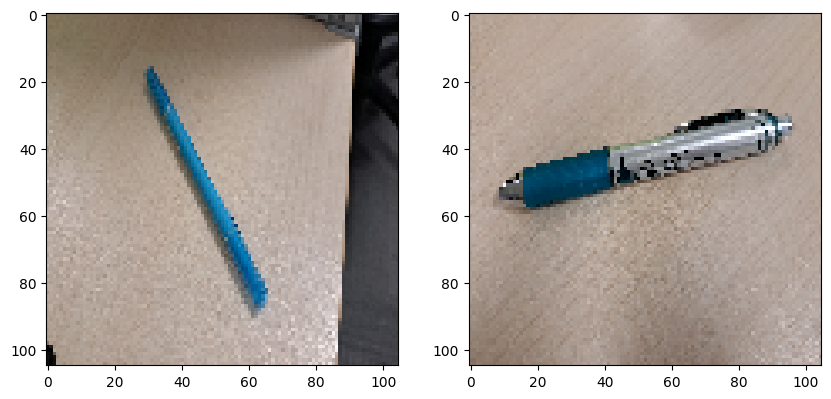

In [16]:
# Modify this value. This value corresponds to the index in the array printed above. 
# If the array above [i] = 0, it means the two images should not match.
i = 0

plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
plt.imshow(test_input[i])
plt.subplot(1,2,2)
plt.imshow(test_val[i])
plt.show()



# Save and load the model to the "model" variable

In [17]:
MODEL_OUTPUT_NAME = "siameseModel"

siamese_model.save(MODEL_OUTPUT_NAME + ".h5")

In [18]:
# Reload the model:
model = tf.keras.models.load_model(MODEL_OUTPUT_NAME + ".h5", 
                                   custom_objects={
                                       "L1Dist": L1Dist,    # From "Build distance layer" - it is a custom layer in = L1Dist()
                                       "BinaryCrossentropy": tf.losses.BinaryCrossentropy
                                       }
                                   )

# Output the model as .tflite file
this may take a while

In [21]:
"""
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_filename = MODEL_OUTPUT_NAME + ".tflite"
with open(tflite_filename, "wb") as f:
    f.write(tflite_model)
"""


'\nimport tensorflow as tf\n\nconverter = tf.lite.TFLiteConverter.from_keras_model(model)\ntflite_model = converter.convert()\ntflite_filename = MODEL_OUTPUT_NAME + ".tflite"\nwith open(tflite_filename, "wb") as f:\n    f.write(tflite_model)\n'